In [1]:
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [2]:
%cd /content/Drive/MyDrive/Sharif/Spring-1400/AIR/Project

/content/Drive/MyDrive/Sharif/Spring-1400/AIR/Project


# Community Detection

<html>
    <div style="direction:rtl;line-height:150%;" dir=rtl>
        <font face="B Nazanin" size=4>
           در این قسمت ابتدا تلاش داریم از خوشه‌بندی گراف برای دسته‌بندی داده‌ها استفاده کنیم. برای این منظور از امبدینگ‌های استفاده شده از بخش‌های قبلی استفاده کرده و برای هر سند برداری عددی فراهم می‌کنیم. (این کار در قسمت‌های قبلی انجام شده و در این مرحله مستقیما از آن‌ها استفاده می‌کنیم.)
           </br>
           سپس برای هر سند میزان شباهت‌ش را با سایر اسناد به کمک معیار شباهت کسینوسی محاسبه می‌کنیم. سپس گرافی از اسناد تهیه می‌کنیم که وزن یال میان هر دو سند میزان شباهت کسینوسی آن‌ها باشد.
           برای سادگی در محاسبات و نتایج بهتر، یال‌هایی که وزن کمی دارند را حذف کرده و گراف شباهت اسناد می‌رسیم.
           در ادامه از الگوریتم‌های معروف دسته‌بندی گراف همچون 
           leiden
           و
           infomap
           استفاده کرده و اسناد را دسته‌بندی می‌کنیم.
        </font>
    </div> 
</html>

## Install and Import Libraries

In [ ]:
!pip install cdlib
!pip install infomap leidenalg wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 228 kB 4.2 MB/s 
     |████████████████████████████████| 14.2 MB 41.9 MB/s 
     |████████████████████████████████| 50 kB 5.2 MB/s 
     |████████████████████████████████| 2.6 MB 41.9 MB/s 
     |████████████████████████████████| 3.1 MB 47.4 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=0c97ede0795c9ecc5db464b0999553a23172f264cd83d3e604904eac846b81d0
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=29085508c44acd9890f0b01aee2fddb5b322dfd397c7b7d6d6277222b630448b
  Stored in directory: /root/.cache/pip/wheels/7d/e4/0c/0c83f70bd0b99ce8aea47a21f8e52502169e7dd17808d12f30
  Created wheel for python-Levenshtein: filename=python_Levenshtein-

In [ ]:
import pandas as pd
import numpy as np
from random import choices

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from networkx import from_numpy_matrix
from cdlib.algorithms import leiden, infomap

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}


## Load Document Vectors

In [ ]:
# data_df = pd.read_csv('DataFrames/transformer_vectors.csv', index_col=0)
data_df = pd.read_csv('DataFrames/fasttext_embedded.csv', index_col=0)
data_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
195528,-0.012402,-0.077719,-0.021008,0.022500,-0.010497,-0.058743,-0.004195,-0.127094,0.062188,-0.000435,...,-0.008159,-0.009081,-0.012941,-0.003692,0.010363,0.014501,-0.026796,0.005985,0.012650,-0.007647
195552,0.018970,-0.001358,-0.003685,-0.000681,-0.020905,0.005530,-0.016388,-0.210833,0.056330,-0.036689,...,-0.088736,-0.006603,0.002338,-0.019635,-0.003202,0.014979,0.013781,0.018346,-0.015892,0.025955
195602,-0.015543,-0.039430,0.024051,0.047467,-0.061052,-0.023567,0.012168,-0.038766,0.027427,-0.010946,...,-0.038852,0.033071,-0.090898,-0.044382,0.015452,0.020029,0.004593,0.012504,-0.012119,-0.003168
184150,0.038575,-0.005869,0.075760,-0.031768,-0.001228,-0.041842,0.053797,-0.142780,0.014443,-0.084863,...,-0.035328,0.018050,0.007826,0.009935,0.061012,0.026952,-0.053276,0.036215,0.049541,-0.005650
195652,-0.024282,-0.067053,0.035873,-0.020247,0.002273,-0.059648,-0.006990,-0.200828,0.078160,-0.006928,...,-0.048727,-0.019131,0.013508,-0.011488,0.025631,-0.000567,-0.023827,-0.000153,0.033275,0.009542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,-0.008621,-0.050148,0.004616,0.049542,-0.013963,-0.075733,0.040471,-0.176395,-0.019623,-0.017218,...,-0.035359,-0.031571,-0.030903,-0.032209,0.043427,0.020357,0.009014,-0.016637,-0.045678,-0.018780
17512,0.058859,-0.035017,0.034872,-0.000129,-0.002077,-0.045292,0.054486,-0.177909,-0.018674,-0.035403,...,-0.040811,0.020185,-0.006459,-0.050347,0.051230,0.002086,0.004679,-0.017196,0.003380,0.012391
17520,0.074162,-0.029601,0.016394,0.003039,-0.022986,-0.043504,-0.012015,-0.178004,-0.029245,-0.013844,...,-0.040048,-0.018998,0.014916,-0.052739,0.043571,0.000794,0.006100,-0.012305,0.003723,0.025204
17537,0.105391,-0.093249,0.062999,0.042043,-0.026794,-0.067085,0.037520,-0.101224,0.011941,0.038550,...,-0.137205,-0.004220,0.041103,-0.066300,0.097025,-0.005896,0.075072,-0.011595,0.050149,0.038464


In [ ]:
X = data_df.values
ids = data_df.index.values

X.shape

(4339, 300)

In [ ]:
# X_pca = PCA(n_components=100).fit_transform(X)

## Create Cosine Similarity Graph

In [ ]:
cos_sim_matrix = cosine_similarity(X)

In [ ]:
threshold = np.quantile(cos_sim_matrix, 0.85)
np.place(cos_sim_matrix, cos_sim_matrix < threshold, 0)

In [ ]:
cos_graph = from_numpy_matrix(cos_sim_matrix)

## Cluster Graph and Find Communities

In [ ]:
leiden_coms = leiden(cos_graph)

In [ ]:
info_coms = infomap(cos_graph)

In [ ]:
results = {
    'leiden':leiden_coms, 
    'infomap':info_coms
}

In [ ]:
for coms_type, coms in results.items():
    print(coms_type)
    sizes = [len(coms.communities[i]) for i in range(len(coms.communities)) if len(coms.communities[i]) >= 100]
    print(len(coms.communities), len(sizes), sizes, f'coverage: {sum(sizes)/len(X)*100:.1f}%')

leiden
196 3 [1915, 1105, 1001] coverage: 92.7%
infomap
247 5 [2802, 397, 350, 192, 109] coverage: 88.7%


<html>
    <div style="direction:rtl;line-height:150%;" dir=rtl>
        <font face="B Nazanin" size=3>
          نتایج بالا نشان می‌دهد در الگوریتم 
          infomap
          توانسته حدود ۸۹ درصد از اسناد را درگروه‌هایی با تعداد اعضای بیشتر از ۳ رقم قرار دهد. این الگوریتم بخش زیادی از اسناد (حدود ۵۰ درصد) را در یک گروه قرار داده و سایر دسته‌ها هر کدام حدود ۲ درصد از اسناد را در بر می‌گیرند. 
          اینگونه می‌توان برداشت کرد که این الگوریتم فضای مسئله ما را به یک گروه کلی و تعدادی گروه نامتعارف دسته‌بندی کرده است.
          </br>
          از طرف دیگر الگوریتم 
          leiden
          حدود 92 درصد از داده‌ها را در 4 دسته مختلف قرار دهد و سایر اسناد را درگروه‌های نامرتبط به آن دسته‌بندی کند. بنابراین می‌توان این ۸ درصد باقی‌مانده را به عنوان یک گروه نامتعارف درنظر گرفت در کنار ۴ انجمن شناسایی‌شده دیگر به یک خوشه‌بندی با ۵ دسته رسید.
        </font>
    </div> 
</html>

In [ ]:
leiden_label = [None] * len(X)

for i, com in enumerate(leiden_coms.communities):
    label = i if len(com) >= 100 else -1
    for j in com:
        leiden_label[j] = label

In [ ]:
info_label = [None] * len(X)

for i, com in enumerate(info_coms.communities):
    label = i if len(com) >= 100 else -1
    for j in com:
        info_label[j] = label

In [ ]:
cluster_df = pd.DataFrame({
    'id': ids,
    'leiden_label': leiden_label, 
    'infomap_label': info_label
})
cluster_df

,id,leiden_label,infomap_label
0,195528,1,0
1,195552,0,0
2,195602,1,3
3,184150,-1,-1
4,195652,2,0
...,...,...,...
4334,4556,0,0
4335,17512,0,0
4336,17520,0,0
4337,17537,-1,-1


In [ ]:
cluster_df.to_csv('DataFrames/communities.csv', index=False)

## Visualize Communities

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
x_tsne = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4339 samples in 0.002s...
[t-SNE] Computed neighbors for 4339 samples in 0.933s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4339
[t-SNE] Computed conditional probabilities for sample 2000 / 4339
[t-SNE] Computed conditional probabilities for sample 3000 / 4339
[t-SNE] Computed conditional probabilities for sample 4000 / 4339
[t-SNE] Computed conditional probabilities for sample 4339 / 4339
[t-SNE] Mean sigma: 0.127305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.905182
[t-SNE] KL divergence after 1000 iterations: 1.857741


In [ ]:
cluster_df['tsne-one'] = x_tsne[:, 0]
cluster_df['tsne-two'] = x_tsne[:, 1]

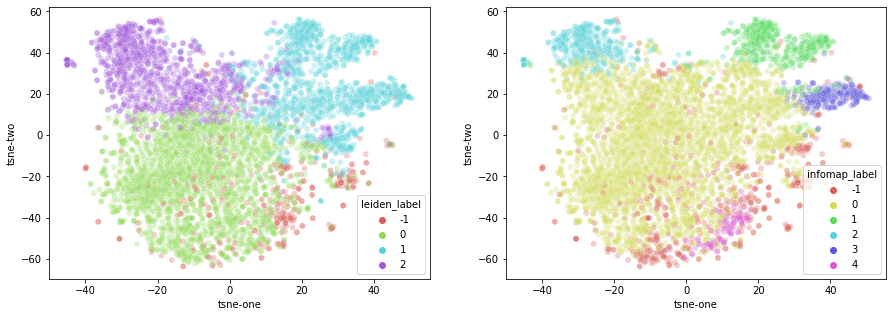

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.scatterplot(
        x = "tsne-one", y = "tsne-two",
        hue='leiden_label',
        palette=sns.color_palette("hls", cluster_df['leiden_label'].nunique()),
        data=cluster_df,
        legend='auto',
        alpha=0.3,
        ax=axs[0]
)

sns.scatterplot(
        x = "tsne-one", y = "tsne-two",
        hue='infomap_label',
        palette=sns.color_palette("hls", cluster_df['infomap_label'].nunique()),
        data=cluster_df,
        legend='auto',
        alpha=0.3,
        ax=axs[1]
)
plt.show()

In [ ]:
cluster_df.to_csv('DataFrames/communities.csv', index=False)

## Sample Communities

In [ ]:
sample_size = 5

In [ ]:
summary_df = pd.read_csv('DataFrames/summary_df_raw.zip', index_col=0)

In [ ]:
# leiden
leiden_sample = dict()
for c in cluster_df['leiden_label'].unique():
    leiden_sample[c] = choices(cluster_df['id'], k=sample_size)

In [ ]:
for label, lst in leiden_sample.items():
    print('#' * 100)
    print('Cluster: ', label, '\n\n')
    for txt in summary_df.loc[lst]['Summary']:
        print(txt)
        print('-' * 50 + '\n')

####################################################################################################
Cluster:  2 


Dan Quillen was an American mathematician who won a Fields medal for his work in algebraic topology.
--------------------------------------------------

Vladimir Abramovich Rokhlin was a mathematician who was born in what is now Azerbaijan and worked in algebraic topology and geometry.
--------------------------------------------------

Henri René Pierre Villat (French: [vila]; 24 December 1879 – 19 March 1972) was a French mathematician. He was professor of fluid mechanics at the University of Paris since 1927. Villat became a member of the French Academy of Sciences in 1932, and its president in 1948.
--------------------------------------------------

Shahriar Shahriari (born May 30, 1956) is an American mathematician. He is the William Polk Russell Professor of Mathematics at Pomona College.
--------------------------------------------------

Bruce Lee Rothschild (bor

In [ ]:
# infomap
info_sample = dict()
for c in cluster_df['infomap_label'].unique():
    info_sample[c] = choices(cluster_df['id'], k=sample_size)

In [ ]:
for label, lst in info_sample.items():
    print('#' * 100)
    print('Cluster: ', label, '\n\n')
    for txt in summary_df.loc[lst]['Summary']:
        print(txt)
        print('-' * 50 + '\n')

####################################################################################################
Cluster:  0 


Michael Fekete was a Hungarian mathematician and set theorist who worked on the transfinite diameter of a set.
--------------------------------------------------

Mireille Bousquet-Mélou (born May 12, 1967) is a French mathematician who specializes in enumerative combinatorics and who works as a senior researcher for the Centre national de la recherche scientifique (CNRS) at the computer science department (LaBRI) of the University of Bordeaux.
--------------------------------------------------

Valérie Berthé (born 16 December 1968) is a French mathematician who works as a director of research for the Centre national de la recherche scientifique (CNRS) at the Institut de Recherche en Informatique Fondamentale (IRIF), a joint project between CNRS and Paris Diderot University. Her research involves symbolic dynamics, combinatorics on words, discrete geometry, numeral syste

# Topic Modeling

<html>
    <div style="direction:rtl;line-height:150%;" dir=rtl>
        <font face="B Nazanin" size=4>
           در این قسمت از 
           Topic Modeling
           و به صورت خاص الگوریتم 
           LDA
           برای دسته‌بندی موضوعی اسناد استفاده می‌کنیم.
           </br>
           در این الگوریتم لازم است اسناد را توکنایز کرده بر اساس مدل جعبه کلمات
           (bag of words)
           به صورت احتمالاتی دسته هر سند را مشخص کنیم. در این الگوریتم لازم است تعداد دسته‌های مدنظر به عنوان ورودی به مدل داده شود. با توجه به نتایج قسمت قبل انتظار داریم تعداد مناسب دسته‌ها چیزی حدود ۵ دسته باید باشد.
        </font>
    </div> 
</html>

## Install and Import libraires

In [ ]:
!pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.models.phrases import Phraser

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stoplist = stopwords.words('english') 

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import seaborn as sns
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Load Data Tokens

In [5]:
data_df = pd.read_csv('DataFrames/summary_df_raw.zip', index_col=0)
data_df

,Summary
195528,Justin Wayne Jacobs (born c. 1981) is an Ameri...
195552,Alexander Schmidt (born 1965) is a German math...
195602,Carl Wolfgang Benjamin Goldschmidt (1807–Febru...
184150,"Xavier Ros Oton (Barcelona, 1988) is a Spanish..."
195652,Athanassios Spyridon Fokas (Greek: Αθανάσιος Σ...
...,...
4556,Richard Hamming was an American mathematician ...
17512,Israil Gelfand was a Ukranian mathematician wh...
17520,Anatoly Malcev was a Russian mathematician not...
17537,Yuri Prokhorov was a Russian mathematician who...


In [6]:
def remove_number(text:str):
    return re.sub(r'[0-9]+', '<No>', text)

def remove_punc(text: str):
    return re.sub(r"[^a-zA-Z0-9']+", ' ', text) 

def clean_text(text: str):
    text = remove_punc(text)
    text = remove_number(text)
    tokens = simple_preprocess(text, deacc=True, min_len=3)
    return [word.lower() for word in tokens if word.lower() not in stoplist]

In [7]:
ids = data_df.index.values
tokens = [clean_text(text) for text in tqdm(data_df['Summary'])]

100%|██████████| 4339/4339 [00:04<00:00, 918.76it/s] 


In [8]:
bigrams = Phrases(tokens, min_count=5, threshold=100)
bigram_mode = Phraser(bigrams)
bigram_tokens = [bigram_mode[i] for i in tqdm(tokens)]

100%|██████████| 4339/4339 [00:01<00:00, 3312.82it/s]


## Create Term-Document Matrix

In [9]:
id2word = corpora.Dictionary(bigram_tokens)
id2word.filter_extremes()
corpus = [id2word.doc2bow(text) for text in tqdm(bigram_tokens)]

100%|██████████| 4339/4339 [00:00<00:00, 14467.91it/s]


## Generate LDA Model

In [ ]:
coherence = []
for k in tqdm(range(2,25)):
    ldamodel = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=10, iterations=100,
                   chunksize = 10000, eval_every = 10, random_state=20)
    ldamodel.save(f"ldamodel_for_{k}topics_Run_10")
    cm = CoherenceModel(model=ldamodel, texts=bigram_tokens, dictionary=id2word, coherence='c_v')
    coherence.append(cm.get_coherence())

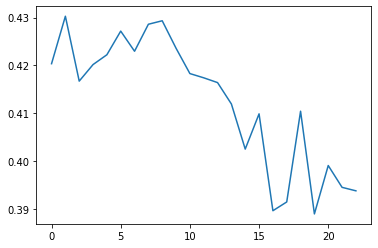

In [15]:
plt.plot(coherence)

In [ ]:
lda_model = LdaMulticore.load('ldamodel_for_16topics_Run_10')

In [13]:
lda_model.print_topics()

[(0,
  '0.019*"computer" + 0.017*"mathematics" + 0.016*"university" + 0.014*"science" + 0.014*"numerical" + 0.013*"professor" + 0.012*"research" + 0.011*"analysis" + 0.010*"known" + 0.009*"work"'),
 (1,
  '0.057*"theory" + 0.041*"worked" + 0.027*"born" + 0.024*"geometry" + 0.022*"known" + 0.019*"analysis" + 0.017*"german" + 0.017*"mathematical" + 0.016*"topology" + 0.015*"contributions"'),
 (2,
  '0.050*"university" + 0.034*"professor" + 0.031*"mathematics" + 0.024*"mathematical" + 0.021*"research" + 0.017*"theory" + 0.016*"born" + 0.012*"analysis" + 0.009*"science" + 0.009*"equations"'),
 (3,
  '0.053*"university" + 0.024*"mathematics" + 0.023*"professor" + 0.022*"theory" + 0.011*"born" + 0.010*"received" + 0.008*"american" + 0.007*"mathematical" + 0.007*"became" + 0.006*"research"'),
 (4,
  '0.055*"university" + 0.032*"mathematics" + 0.021*"professor" + 0.019*"american" + 0.013*"science" + 0.012*"mathematical" + 0.011*"research" + 0.010*"born" + 0.010*"college" + 0.009*"institute"'),

## Visualize Topics

In [14]:
pyLDAvis.enable_notebook()

In [16]:
lda_display = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(lda_display, 'topic.html')
lda_display

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.125510  0.024919       1        1  11.606442
3      0.044048  0.000836       2        1   9.812596
2      0.093034 -0.088461       3        1   9.737013
15    -0.018589  0.043167       4        1   8.108462
5      0.046605 -0.048840       5        1   6.841185
7      0.003389  0.031616       6        1   6.797082
12    -0.034576 -0.153128       7        1   6.683463
0      0.048889  0.006236       8        1   6.538503
1     -0.163365 -0.138987       9        1   6.401852
10    -0.006267 -0.021432      10        1   5.817732
13     0.141211  0.040728      11        1   5.741027
6      0.076743  0.050503      12        1   4.774534
14     0.061067  0.001025      13        1   3.023462
8     -0.100704  0.135270      14        1   2.998272
11    -0.177576  0.005786      15        1   2.948572
9     -0.139419  0.110763      16        1   2.169803, topic_info=          Term         Freq        Total Category  logprob  loglift
39      theory  2252.000000  2252.000000  Default  30.0000  30.0000
34      german   765.000000   765.000000  Default  29.0000  29.0000
273     worked   880.000000   880.000000  Default  28.0000  28.0000
33    geometry   911.000000   911.000000  Default  27.0000  27.0000
0     american  1317.000000  1317.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
480  september    14.838265   266.584750  Topic16  -5.2846   0.9421
0     american    18.122590  1317.226632  Topic16  -5.0847  -0.4556
117      named    13.272798   179.636108  Topic16  -5.3961   1.2253
235    october    13.996081   301.501488  Topic16  -5.3431   0.7605
527      later    13.259930   202.209747  Topic16  -5.3971   1.1060

[1144 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2766      2  0.095101  abdus_salam
2766     11  0.190202  abdus_salam
2766     12  0.570607  abdus_salam
3612      1  0.059691         abel
3612      6  0.059691         abel
...     ...       ...          ...
363      13  0.923876        zhang
1429      7  0.134292     zhejiang
1429     13  0.805753     zhejiang
3783      6  0.534308         zuse
3783     12  0.178103         zuse

[4689 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 16, 6, 8, 13, 1, 2, 11, 14, 7, 15, 9, 12, 10])

In [21]:
def get_topic_probs(prbs, size=16):
    result = [0] * 16
    for i, prob in prbs:
        result[i] = prob
    return result

In [19]:
topics = [lda_model[i] for i in tqdm(corpus)]

100%|██████████| 4339/4339 [00:04<00:00, 1027.22it/s]


In [22]:
probs = [get_topic_probs(i) for i in tqdm(topics)]


100%|██████████| 4339/4339 [00:00<00:00, 13391.07it/s]


In [23]:
topic_df = pd.DataFrame(probs, index=ids)
topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
195528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093781,0.000000,0.000000,0.000000,0.883193,0.000000,0.000000
195552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238648,0.000000,0.698852,0.000000,0.000000,0.000000
195602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066769,0.087995,0.471314,0.209770,0.000000,0.135506,0.000000,0.000000,0.000000,0.000000
184150,0.000000,0.000000,0.798200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139300,0.000000
195652,0.000000,0.000000,0.228010,0.000000,0.000000,0.730323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,0.000000,0.000000,0.000000,0.335192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555433,0.000000,0.000000,0.000000,0.000000
17512,0.000000,0.823060,0.000000,0.000000,0.000000,0.109632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17520,0.000000,0.581574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293426,0.000000,0.000000,0.000000
17537,0.010417,0.637184,0.010417,0.216982,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417


In [25]:
topic_df.to_csv('DataFrames/topic.csv')